<a href="https://colab.research.google.com/github/thomasdevasia/deep-image-prior/blob/master/denoise_sar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/thomasdevasia/deep-image-prior
# !mv deep-image-prior/* ./
%cd deep-image-prior

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 406 (delta 56), reused 94 (delta 44), pack-reused 289
Receiving objects: 100% (406/406), 123.26 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (211/211), done.
/content/deep-image-prior


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

import scipy.io as sio

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [3]:
# png SAR image
fnamep = 'data/denoising/SAR3.png'
# .mat SAR images
fname = 'data/denoising/CL7.mat'
# fname = 'data/denoising/CL8.mat'
# fname = 'data/denoising/CL9.mat'

# Load and prepare Image

In [4]:
# reading mat files
test = sio.loadmat(fname)
intImage = test['x2']
temp = pil_to_np(intImage)
img_pil = np_to_pil(temp)
img_pil = crop_image(img_pil, d=32)
# img_np = 255*pil_to_np(img_pil)
img_np = pil_to_np(img_pil)
# img_np

In [5]:
img_np.shape

(1, 672, 672)

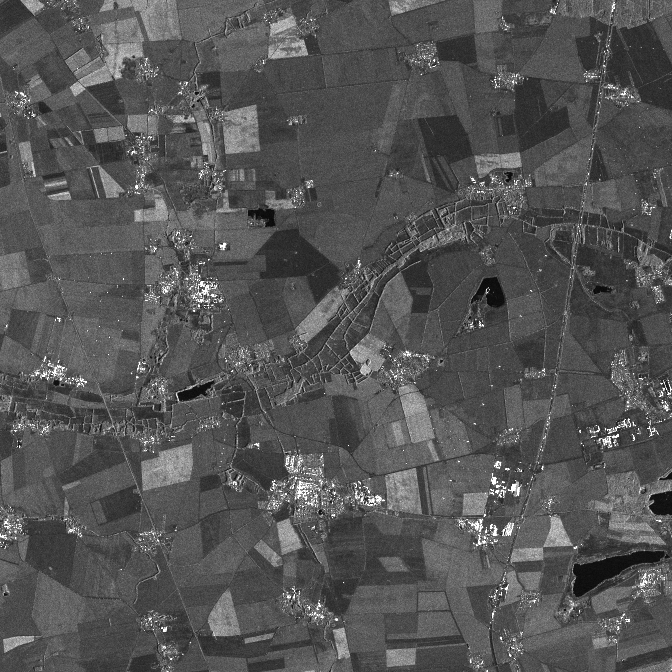

In [6]:
img_pil

In [7]:
# img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
# img_noisy_np = pil_to_np(img_noisy_pil)

# img_pil = img_noisy_pil
# img_np = img_noisy_np

# plot_image_grid([img_np], 4, 5);

In [8]:
# im = crop_image(get_image(fname, imsize)[0], d=128)
# im.size

In [9]:
# # reading png files
# # img_pil = get_image(fname, imsize)[0]
# img_pil = crop_image(get_image(fnamep, imsize)[0], d=32)
# # converting to numpy
# img_np = pil_to_np(img_pil)
# # img_np

In [10]:
# # # adding speckle noise
# def get_noisy_img(img_np, sigma):
#   """Adds noise to an image.
    
#   Args: 
#       img_np: image, np.array with values from 0 to 1
#       sigma: std of the noise
#   """

#   np.random.seed(42)

#   noise = np.random.normal(loc=1, scale=sigma_, size=img_np.shape)

#   # multiplicative noise for speckle noise
#   # imgNoise = img_np + (img_np * noise)
#   imgNoise = np.log(img_np * noise)

#   img_noisy_np = np.clip(abs(imgNoise), 0, 1).astype(np.float32)
    
#   img_noisy_pil = np_to_pil(img_noisy_np)

#   return img_noisy_pil, img_noisy_np

In [11]:
# correct way
def generateAddSpeckle(img_np, L):

    '''

    Creates multiplicative speckled image with number of looks L. L increases lower noise effect, L is lower noise is strong. 

    '''

    sum_ = 0

    for i in range(L):

        seq1 = np.random.randn(img_np.shape[1], img_np.shape[2])

        seq2 = np.random.randn(img_np.shape[1], img_np.shape[2])

        temp = np.multiply(seq1, seq1) + np.multiply(seq2, seq2)

        sum_ = sum_ + temp/2

        #print(i)

    speckle_ = np.multiply(sum_,1/L)

    img_noisy_np = np.multiply(img_np, speckle_)
    # img_noisy_np = np.log(np.multiply(img_np, speckle_))

    img_noisy_np = np.clip(img_noisy_np, 0, 1).astype(np.float32)

    img_noisy_pil = np_to_pil(img_noisy_np)

    return img_noisy_pil, img_noisy_np

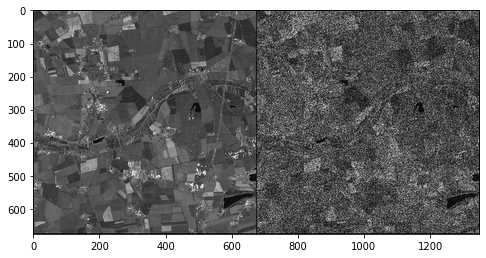

((1, 672, 672), (1, 672, 672))

In [12]:
# with ground truth available
# img_noisy_pil, img_noisy_np = get_noisy_img(img_np, sigma_)
img_noisy_pil, img_noisy_np = generateAddSpeckle(img_np, 1)
plot_image_grid([img_np, img_noisy_np],4,6)
(img_np.shape, img_noisy_np.shape)

In [13]:
# when ground truth not available
# img_noisy_pil = img_pil
# img_noisy_np = img_np

In [14]:
# img_pil
# ar = np.array(img_pil)
# npImg = ar.transpose(2,0,1).astype(np.float32)/255
# img_noisy_np

In [15]:
# noise = np.random.normal(scale=sigma, size=img_np.shape)
# img_noisy_np = np.clip((img_np * noise),0,1).astype(np.float32)
# img_noisy_pil = np_to_pil(img_noisy_np)
# img_noisy_np

# plot_image_grid
# plot_image_grid([img_noisy_np],4,6)
# img_pil

In [16]:
# # from torch.cuda.random import seed
# # checking for the noise to add
# # np.log(img_np * noise)
# # img_np
# np.random.seed(42)
# # noise = np.random.normal(scale=sigma_, size=img_np.shape)
# noise = np.random.uniform(0, 1, img_np.shape)

# print(img_np.shape, noise.shape)
# # imgNoise = img_np + noise
# imgNoise = np.log(img_np + noise)
# # imgNoise = img_np + (img_np * noise)
# res = np.clip(imgNoise, 0, 1).astype(np.float32)
# plot_image_grid([res],4,6)

In [17]:
# # add noise
# img_noisy_np = get_noisy_img(img_np, sigma_)

In [18]:
# plot_image_grid([img_np, img_noisy_np], 4, 6);
# n_channels = max(x.shape[0] for x in [img_np, img_noisy_np])
# img_noisy_np.shape

# Define model

In [19]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
# 0.0001 0.001 0.01 0.1
LR = 0.001

# adam LBFGS 
OPTIMIZER='adam'
# OPTIMIZER='LBFGS'

show_every = 1000
exp_weight=0.99

In [20]:
# 3000 4000 6000 10000 15000
num_iter = 3000
# 16 32 48 64
input_depth = 16
figsize = 4 

In [21]:
# returns a model

# unet
# net = get_net(input_depth, 'UNet', pad,
#               skip_n33d=128, 
#               skip_n33u=128, 
#               skip_n11=4, 
#               num_scales=5,
#               n_channels=1,
#               upsample_mode='bilinear').type(dtype)

# resnet
# net = ResNet(input_depth, 1, 10, 16, need_sigmoid=True, act_fun='LeakyReLU')
# net = net.type(dtype)

# texture_nets
# net = get_net(input_depth, 'texture_nets', pad,
#               skip_n33d=128, 
#               skip_n33u=128, 
#               skip_n11=4, 
#               num_scales=5,
#               n_channels=1,
#               upsample_mode='bilinear').type(dtype)

# net = get_texture_nets(inp=1, conv_num=input_depth, ratios=[32, 16, 8, 4, 2, 1], 
#                        fill_noise=False, pad=pad).type(dtype)
# --------------------------------------
# skip
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              n_channels=1,
              upsample_mode='bilinear').type(dtype)

inside skip


In [22]:
# ./utils/common_utils.py
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0]), noise_type='n').type(dtype).detach()
net_input.shape

torch.Size([1, 16, 672, 672])

In [23]:
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

Number of params: 2199077


In [24]:
# Loss
mse = torch.nn.MSELoss().type(dtype)
# noise to change and see
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

# Optimize Model

In [25]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0

In [26]:
# Loss funftion printing image
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    # print(out.shape, img_noisy_torch.shape)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    # print(img_noisy_np.shape, out.detach().cpu().numpy()[0].shape)
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # So 'PSRN_gt', 'PSNR_gt_sm' only when ground truth is provided
    print('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), end='')

    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
         
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

In [27]:
p = get_params(OPT_OVER, net, net_input)

In [27]:
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = torch_to_np(net(net_input))

In [ ]:
compare_psnr(img_noisy_np, out_np) 

In [ ]:
compare_psnr(img_np, out_np) 

In [ ]:
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

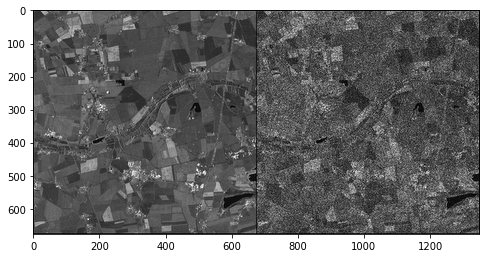

Starting optimization with ADAM
Iteration 00000    Loss 0.106167   PSNR_noisy: 9.740103   PSRN_gt: 12.256796 PSNR_gt_sm: 12.256796

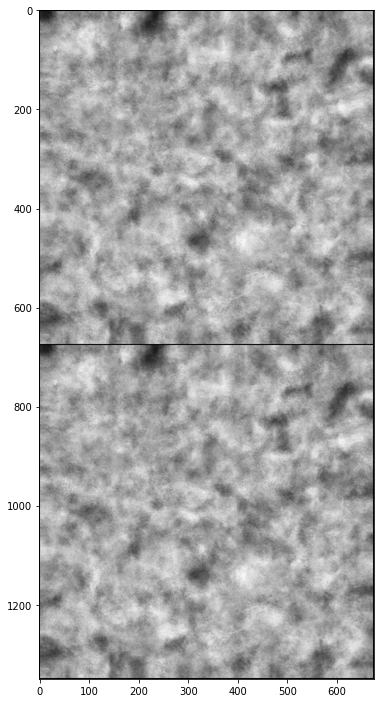

Iteration 00001    Loss 0.104487   PSNR_noisy: 9.809361   PSRN_gt: 12.368369 PSNR_gt_sm: 12.272526Iteration 00002    Loss 0.098133   PSNR_noisy: 10.081832   PSRN_gt: 12.845962 PSNR_gt_sm: 12.291177Iteration 00003    Loss 0.081079   PSNR_noisy: 10.910904   PSRN_gt: 14.560822 PSNR_gt_sm: 12.320251Iteration 00004    Loss 0.072224   PSNR_noisy: 11.413184   PSRN_gt: 15.786941 PSNR_gt_sm: 12.356130Iteration 00005    Loss 0.066141   PSNR_noisy: 11.795263   PSRN_gt: 16.845719 PSNR_gt_sm: 12.399030Iteration 00006    Loss 0.061457   PSNR_noisy: 12.114270   PSRN_gt: 17.846466 PSNR_gt_sm: 12.448417Iteration 00007    Loss 0.058696   PSNR_noisy: 12.313945   PSRN_gt: 18.532593 PSNR_gt_sm: 12.502972Iteration 00008    Loss 0.056681   PSNR_noisy: 12.465616   PSRN_gt: 19.115038 PSNR_gt_sm: 12.562313Iteration 00009    Loss 0.055225   PSNR_noisy: 12.578650   PSRN_gt: 19.590862 PSNR_gt_sm: 12.626152Iteration 00010    Loss 0.054438   PSNR_noisy: 12.641009   PSRN_gt: 19.855390 PSNR_gt_sm: 12.693753Iteration 0

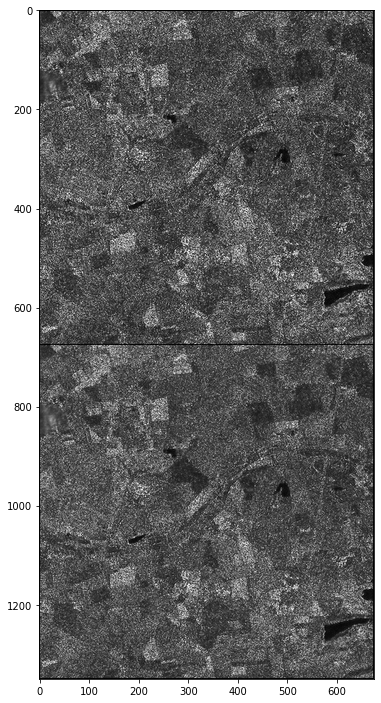

Iteration 01001    Loss 0.019931   PSNR_noisy: 17.004656   PSRN_gt: 15.225103 PSNR_gt_sm: 16.739667Iteration 01002    Loss 0.019938   PSNR_noisy: 17.003158   PSRN_gt: 15.255059 PSNR_gt_sm: 16.735524Iteration 01003    Loss 0.020017   PSNR_noisy: 16.986030   PSRN_gt: 15.361415 PSNR_gt_sm: 16.732645Iteration 01004    Loss 0.020100   PSNR_noisy: 16.967969   PSRN_gt: 15.178590 PSNR_gt_sm: 16.727929Iteration 01005    Loss 0.019843   PSNR_noisy: 17.023919   PSRN_gt: 15.270819 PSNR_gt_sm: 16.723843Iteration 01006    Loss 0.019991   PSNR_noisy: 16.991551   PSRN_gt: 15.278272 PSNR_gt_sm: 16.720135Iteration 01007    Loss 0.019880   PSNR_noisy: 17.015897   PSRN_gt: 15.297931 PSNR_gt_sm: 16.716506Iteration 01008    Loss 0.019936   PSNR_noisy: 17.003555   PSRN_gt: 15.221803 PSNR_gt_sm: 16.712259Iteration 01009    Loss 0.019960   PSNR_noisy: 16.998346   PSRN_gt: 15.326637 PSNR_gt_sm: 16.709203Iteration 01010    Loss 0.019864   PSNR_noisy: 17.019263   PSRN_gt: 15.249789 PSNR_gt_sm: 16.705270Iteration 

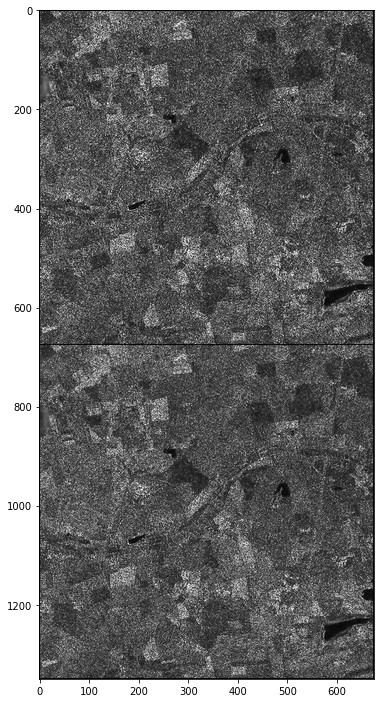

Iteration 02001    Loss 0.015652   PSNR_noisy: 18.054242   PSRN_gt: 14.680712 PSNR_gt_sm: 15.742226Iteration 02002    Loss 0.015716   PSNR_noisy: 18.036592   PSRN_gt: 14.730351 PSNR_gt_sm: 15.740923Iteration 02003    Loss 0.015696   PSNR_noisy: 18.042230   PSRN_gt: 14.686930 PSNR_gt_sm: 15.739162Iteration 02004    Loss 0.015660   PSNR_noisy: 18.052191   PSRN_gt: 14.748241 PSNR_gt_sm: 15.737993Iteration 02005    Loss 0.015669   PSNR_noisy: 18.049662   PSRN_gt: 14.692983 PSNR_gt_sm: 15.736288Iteration 02006    Loss 0.015687   PSNR_noisy: 18.044601   PSRN_gt: 14.698086 PSNR_gt_sm: 15.734663Iteration 02007    Loss 0.015728   PSNR_noisy: 18.033326   PSRN_gt: 14.715900 PSNR_gt_sm: 15.733361Iteration 02008    Loss 0.015719   PSNR_noisy: 18.035777   PSRN_gt: 14.694036 PSNR_gt_sm: 15.731834Iteration 02009    Loss 0.015730   PSNR_noisy: 18.032686   PSRN_gt: 14.653094 PSNR_gt_sm: 15.729939Iteration 02010    Loss 0.015872   PSNR_noisy: 17.993731   PSRN_gt: 14.775954 PSNR_gt_sm: 15.729391Iteration 

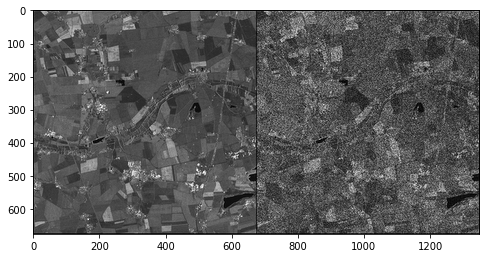

Starting optimization with ADAM
Iteration 00000    Loss 0.086641   PSNR_noisy: 10.622777   PSRN_gt: 13.634123 PSNR_gt_sm: 13.634123

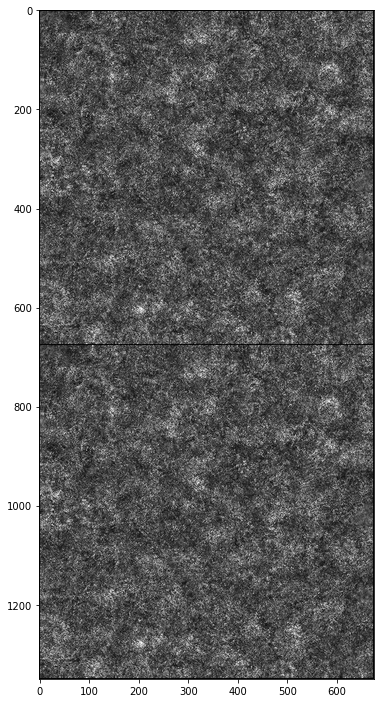

Iteration 00001    Loss 0.094505   PSNR_noisy: 10.245444   PSRN_gt: 12.859274 PSNR_gt_sm: 13.688970Iteration 00002    Loss 0.072835   PSNR_noisy: 11.376603   PSRN_gt: 15.219326 PSNR_gt_sm: 13.748577Iteration 00003    Loss 0.065832   PSNR_noisy: 11.815632   PSRN_gt: 16.336091 PSNR_gt_sm: 13.808184Iteration 00004    Loss 0.062110   PSNR_noisy: 12.068386   PSRN_gt: 17.240954 PSNR_gt_sm: 13.870000Iteration 00005    Loss 0.060485   PSNR_noisy: 12.183508   PSRN_gt: 17.691778 PSNR_gt_sm: 13.933167Iteration 00006    Loss 0.059344   PSNR_noisy: 12.266254   PSRN_gt: 18.016554 PSNR_gt_sm: 13.997137Iteration 00007    Loss 0.057322   PSNR_noisy: 12.416824   PSRN_gt: 18.565311 PSNR_gt_sm: 14.060824Iteration 00008    Loss 0.056367   PSNR_noisy: 12.489756   PSRN_gt: 18.854575 PSNR_gt_sm: 14.123823Iteration 00009    Loss 0.055868   PSNR_noisy: 12.528389   PSRN_gt: 19.033851 PSNR_gt_sm: 14.186578Iteration 00010    Loss 0.055163   PSNR_noisy: 12.583502   PSRN_gt: 19.385779 PSNR_gt_sm: 14.250385Iteration 

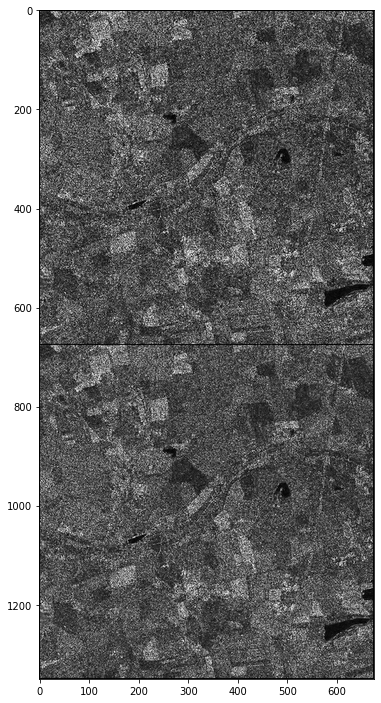

Iteration 01001    Loss 0.014901   PSNR_noisy: 18.267990   PSRN_gt: 14.610643 PSNR_gt_sm: 15.740146Iteration 01002    Loss 0.014897   PSNR_noisy: 18.268930   PSRN_gt: 14.617480 PSNR_gt_sm: 15.738034Iteration 01003    Loss 0.014875   PSNR_noisy: 18.275313   PSRN_gt: 14.629700 PSNR_gt_sm: 15.736020Iteration 01004    Loss 0.014862   PSNR_noisy: 18.279287   PSRN_gt: 14.621636 PSNR_gt_sm: 15.733979Iteration 01005    Loss 0.014870   PSNR_noisy: 18.276764   PSRN_gt: 14.618122 PSNR_gt_sm: 15.731933Iteration 01006    Loss 0.014962   PSNR_noisy: 18.249995   PSRN_gt: 14.611753 PSNR_gt_sm: 15.729975Iteration 01007    Loss 0.014995   PSNR_noisy: 18.240436   PSRN_gt: 14.622488 PSNR_gt_sm: 15.728213Iteration 01008    Loss 0.015051   PSNR_noisy: 18.224322   PSRN_gt: 14.613838 PSNR_gt_sm: 15.726389Iteration 01009    Loss 0.015125   PSNR_noisy: 18.203187   PSRN_gt: 14.609712 PSNR_gt_sm: 15.724635Iteration 01010    Loss 0.015149   PSNR_noisy: 18.196269   PSRN_gt: 14.584443 PSNR_gt_sm: 15.722693Iteration 

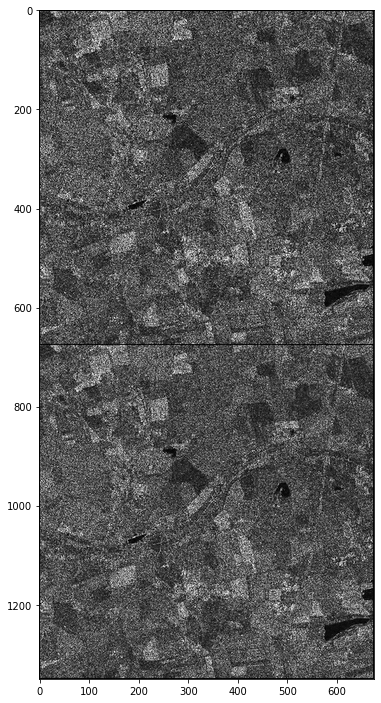

Iteration 02001    Loss 0.010705   PSNR_noisy: 19.703949   PSRN_gt: 14.147499 PSNR_gt_sm: 14.925810Iteration 02002    Loss 0.010851   PSNR_noisy: 19.645311   PSRN_gt: 14.167148 PSNR_gt_sm: 14.925691Iteration 02003    Loss 0.010893   PSNR_noisy: 19.628602   PSRN_gt: 14.177151 PSNR_gt_sm: 14.925695Iteration 02004    Loss 0.010719   PSNR_noisy: 19.698497   PSRN_gt: 14.174443 PSNR_gt_sm: 14.925509Iteration 02005    Loss 0.010831   PSNR_noisy: 19.653211   PSRN_gt: 14.142389 PSNR_gt_sm: 14.925091Iteration 02006    Loss 0.010734   PSNR_noisy: 19.692225   PSRN_gt: 14.166422 PSNR_gt_sm: 14.924868Iteration 02007    Loss 0.010741   PSNR_noisy: 19.689558   PSRN_gt: 14.175753 PSNR_gt_sm: 14.924740Iteration 02008    Loss 0.010718   PSNR_noisy: 19.698760   PSRN_gt: 14.146886 PSNR_gt_sm: 14.924252Iteration 02009    Loss 0.010758   PSNR_noisy: 19.682715   PSRN_gt: 14.172829 PSNR_gt_sm: 14.924109Iteration 02010    Loss 0.010677   PSNR_noisy: 19.715662   PSRN_gt: 14.146778 PSNR_gt_sm: 14.923617Iteration 

In [27]:
# function for l 1 to 20

L_value = []

before_psnr_noise = []

final_psnr_noise = []
final_psnr_gt = []

for i in range(1,6):
  L_value.append(i)

  img_noisy_pil, img_noisy_np = generateAddSpeckle(img_np, 2)
  plot_image_grid([img_np, img_noisy_np],4,6)
  
  before_psnr_noise.append(compare_psnr(img_np,img_noisy_np))

  net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0]), noise_type='n').type(dtype).detach()

  mse = torch.nn.MSELoss().type(dtype)
  img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()
  out_avg = None
  last_net = None
  psrn_noisy_last = 0
  i = 0

  p = get_params(OPT_OVER, net, net_input)

  optimize(OPTIMIZER, p, closure, LR, num_iter)

  out_np = torch_to_np(net(net_input))

  final_psnr_noise.append(compare_psnr(img_noisy_np, out_np)) 

  final_psnr_gt.append(compare_psnr(img_np, out_np))


In [29]:
import pandas as pd

table = pd.DataFrame({
    'L_value':L_value,
    'before_psnr_noise':before_psnr_noise,
    'final_psnr_noise':final_psnr_noise,
    'final_psnr_gt':final_psnr_gt
}).set_index('L_value')

table

before_psnr_noise  final_psnr_noise  final_psnr_gt
L_value                                                    
1                13.207773         19.621604      14.250345
2                13.181558         20.594254      14.023946

#----------------------

In [ ]:
(img_pil.size[1], img_pil.size[0])

In [ ]:
zero  = torch.zeros([1 ,32 ,544 ,896])
var=1./10

In [ ]:
res = zero.normal_()*var
res<0

In [ ]:
img_noisy_np.shape

In [ ]:
torch.zeros([4,2,3])

In [ ]:
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, [2,5,8])

In [ ]:
# np_to_torch(s).shape
torch.from_numpy(s).shape